<a href="https://colab.research.google.com/github/hksantosh/eip/blob/master/PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [7]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
12922,resized/12924.jpg,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
10237,resized/10239.jpg,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
11847,resized/11849.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
6730,resized/6731.jpg,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0
5509,resized/5510.jpg,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [8]:
val_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
8113,resized/8114.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
8618,resized/8619.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
5481,resized/5482.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0
6513,resized/6514.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
7894,resized/7895.jpg,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0


In [9]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

len(train_gen), len(valid_gen)

(360, 31)

In [10]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [11]:
images.shape, targets.get('gender_output').shape, targets.get('age_output').shape

((32, 224, 224, 3), (32, 2), (32, 5))

In [12]:
backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(256, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.06)(in_layer)
    neck = Dense(512, activation="relu")(neck)
    #neck = Dropout(0.05)(in_layer)
    #neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# freeze backbone
#for layer in backbone.layers:
#	layer.trainable = False

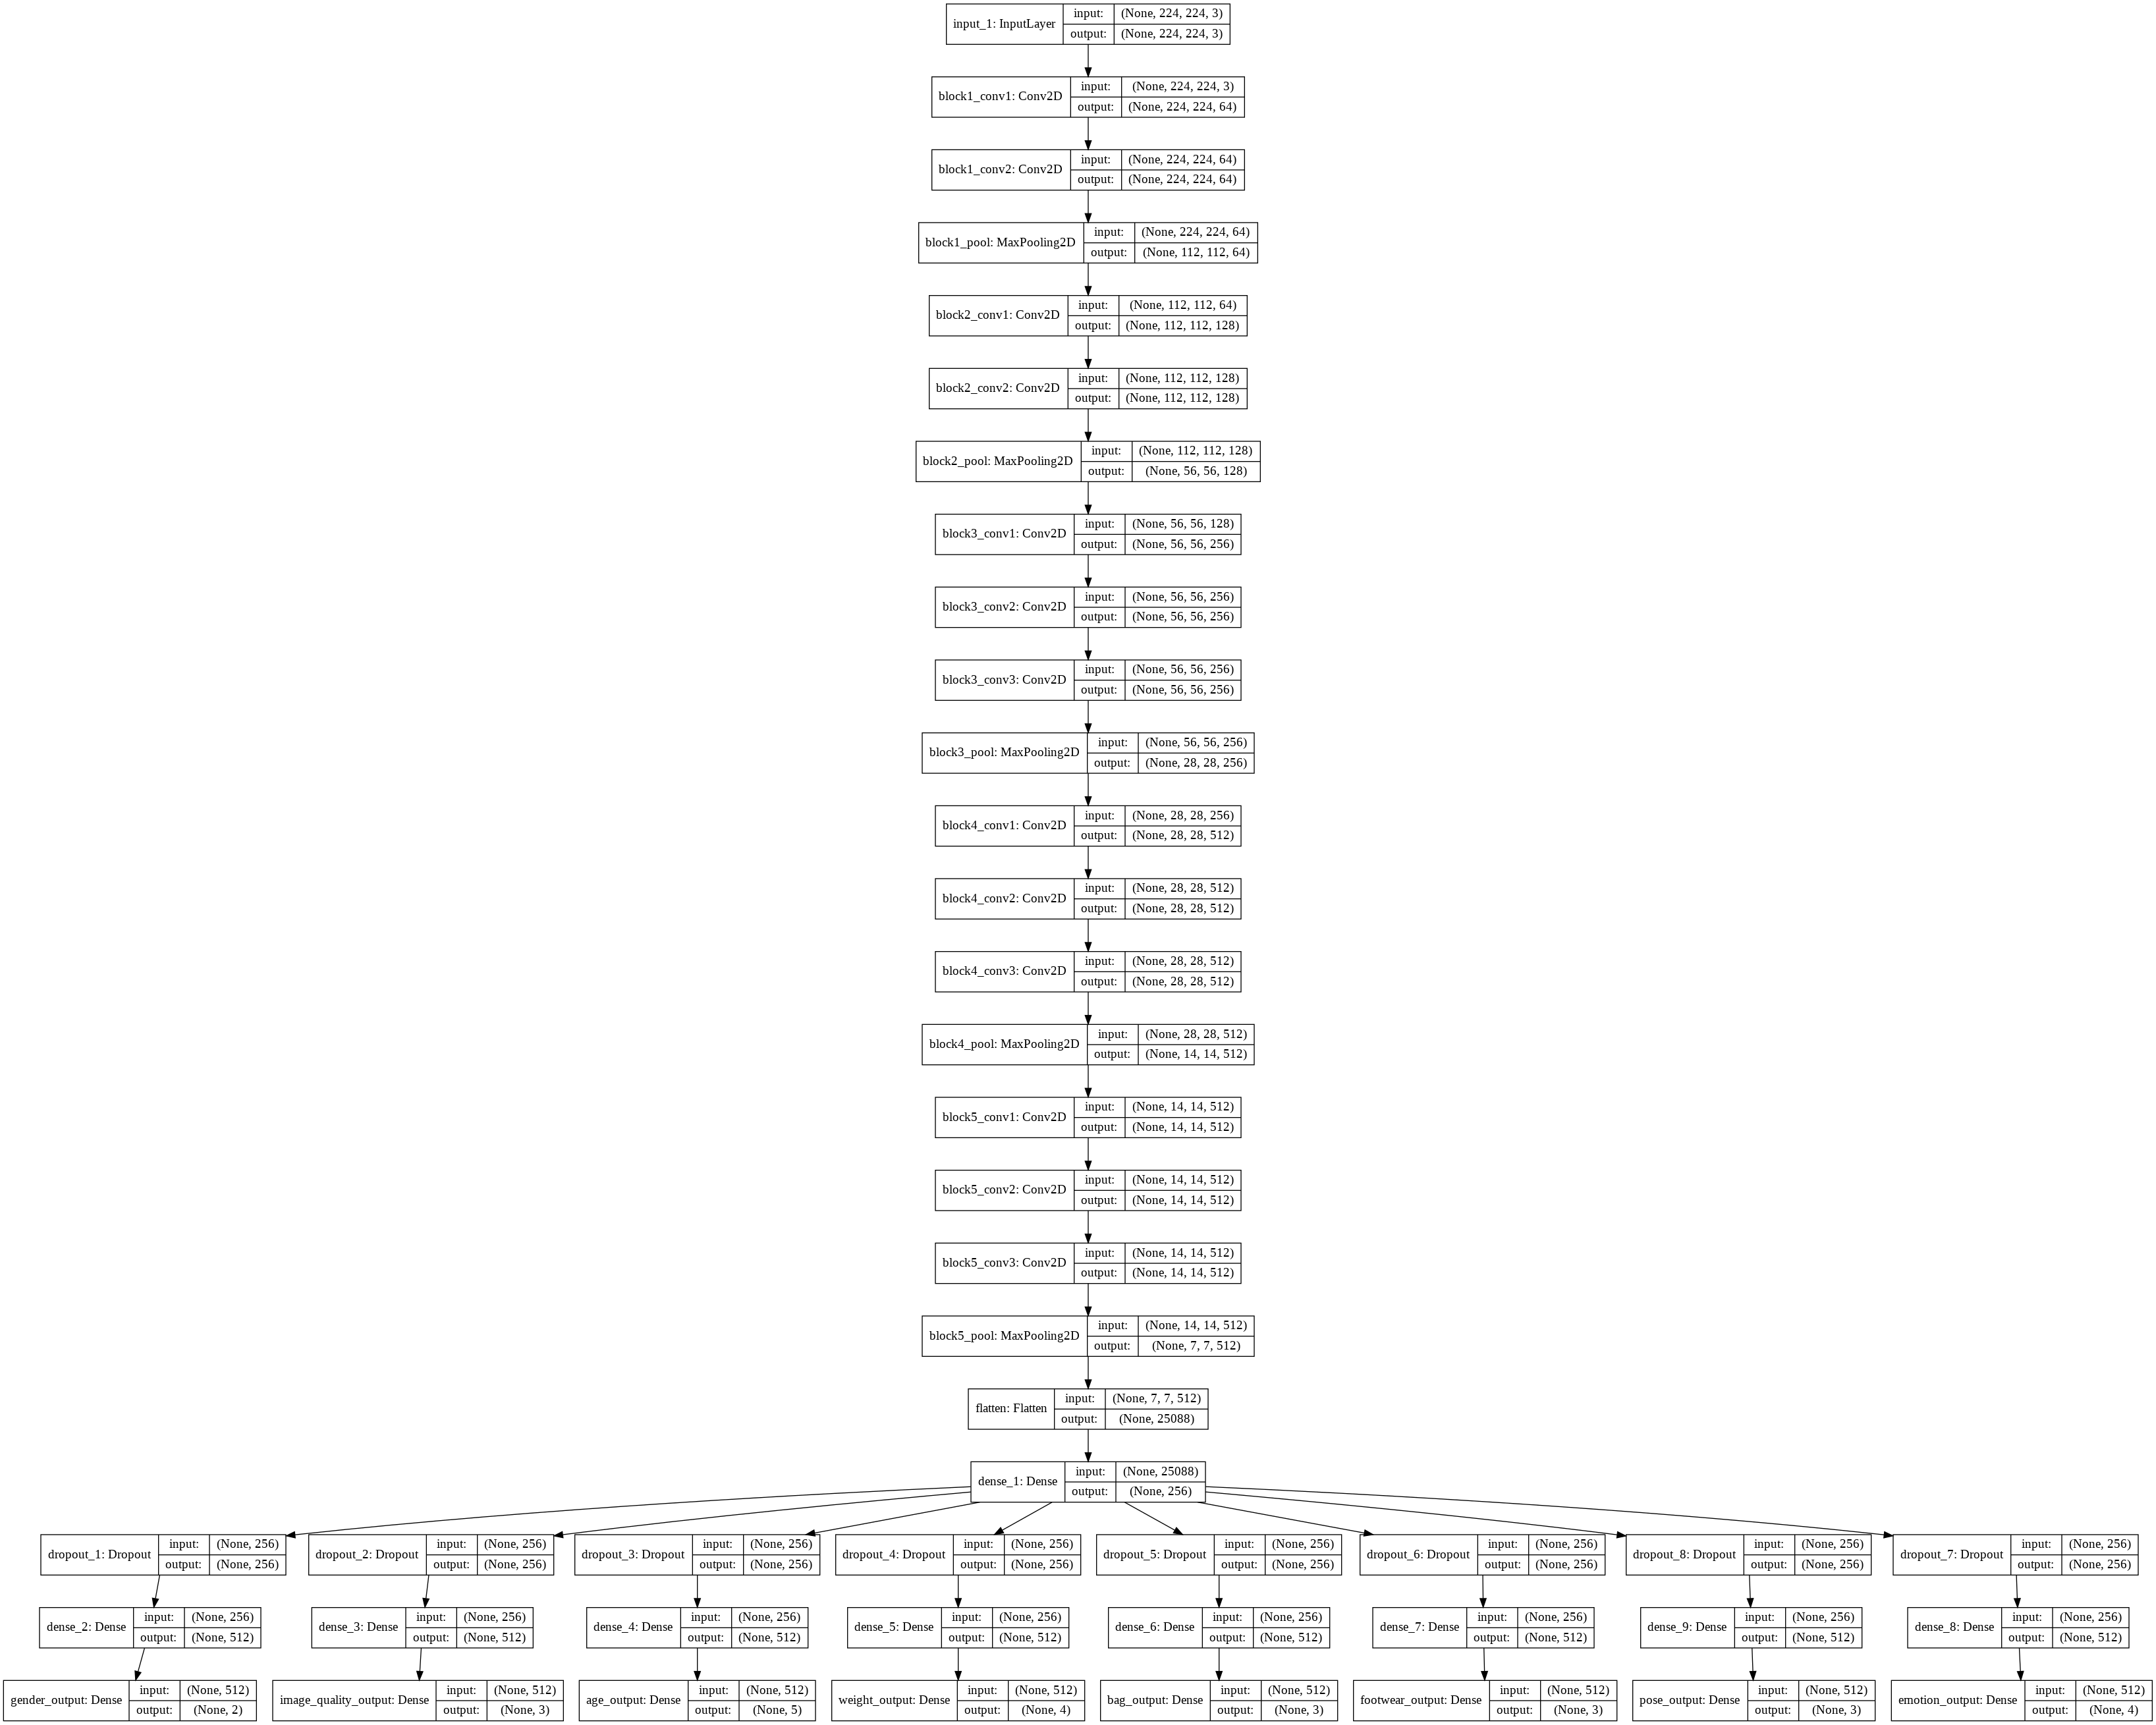

In [14]:
plot_model(model, show_shapes=True)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [16]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
 	"bag_output": "categorical_crossentropy",
 	"footwear_output": "categorical_crossentropy",
 	"pose_output": "categorical_crossentropy",
 	"emotion_output": "categorical_crossentropy"
}

loss_weights = {
    "gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0, "weight_output": 1.0,
    "bag_output": 1.0,  "footwear_output": 1.0,  "pose_output": 1.0,  "emotion_output": 1.0
    }

opt = SGD(lr=0.001, momentum=0.5)
model.compile(
    optimizer=opt,
    loss=losses,
    loss_weights=loss_weights,
    metrics=["accuracy"]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=75,
    verbose=1
)




Epoch 1/75





360/360 [==============================] - 104s 290ms/step - loss: 7.8675 - gender_output_loss: 0.6789 - image_quality_output_loss: 0.9826 - age_output_loss: 1.4433 - weight_output_loss: 0.9987 - bag_output_loss: 0.9340 - footwear_output_loss: 0.9597 - pose_output_loss: 0.9346 - emotion_output_loss: 0.9358 - gender_output_acc: 0.5722 - image_quality_output_acc: 0.5543 - age_output_acc: 0.3924 - weight_output_acc: 0.6361 - bag_output_acc: 0.5563 - footwear_output_acc: 0.5496 - pose_output_acc: 0.6161 - emotion_output_acc: 0.7097 - val_loss: 7.8460 - val_gender_output_loss: 0.6664 - val_image_quality_output_loss: 0.9884 - val_age_output_loss: 1.4306 - val_weight_output_loss: 1.0037 - val_bag_output_loss: 0.9435 - val_footwear_output_loss: 0.9486 - val_pose_output_loss: 0.9319 - val_emotion_output_loss: 0.9329 - val_gender_output_acc: 0.6094 - val_image_quality_output_acc: 0.5454 - val_age_output_acc: 0.4017 - val_weight_output_acc: 0.6285 - val_bag_output_acc: 0.5605 -